In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# torch imports
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# custom imports
from ddpm import Diffusion
from model import UNet

from dataset.helpers import im_normalize, tens2image
from dataset import SpritesDataset

def show(imgs, title=None, fig_titles=None, save_path=None): 

    if fig_titles is not None:
        assert len(imgs) == len(fig_titles)

    fig, axs = plt.subplots(1, ncols=len(imgs), figsize=(15, 5))
    for i, img in enumerate(imgs):
        axs[i].imshow(img)
        axs[i].axis('off')
        if fig_titles is not None:
            axs[i].set_title(fig_titles[i])

    if title is not None:
        plt.suptitle(title)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)

    plt.show()


Dataset shape: (40000, 16, 16, 3)


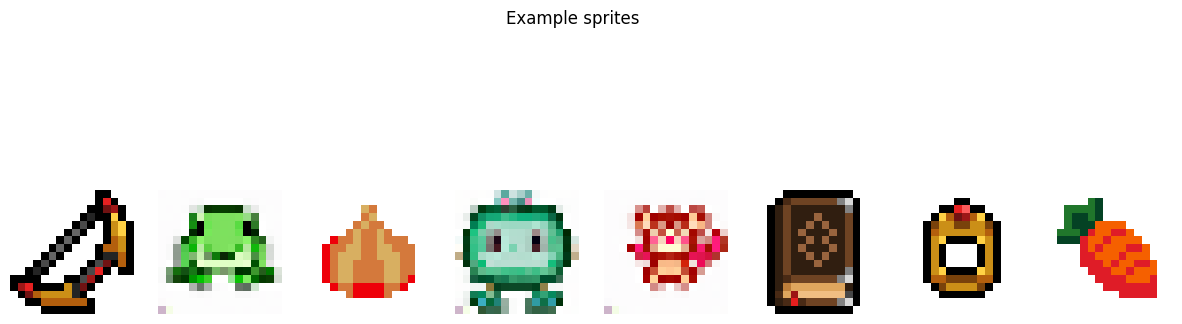

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 2929 # change it to any integer you want to see different results.
torch.manual_seed(seed)

os.makedirs('assets/', exist_ok=True)

# dataset and dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]
])

batch_size = 8
trainset = SpritesDataset(transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)

images  = next(iter(trainloader))
# visualize examples
example_images = np.stack([im_normalize(tens2image(images[idx])) for idx in range(batch_size)], axis=0)
show(example_images, 'Example sprites', save_path='assets/example.png')




tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 14

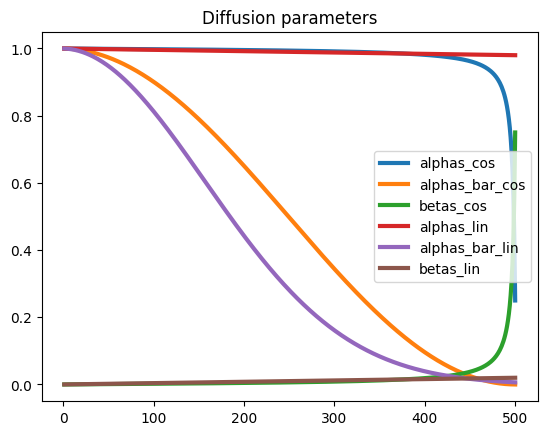

In [8]:


################## Diffusion class ##################
# TASK 1: Implement beta, alpha, and alpha_hat 
diffusion = Diffusion(device=device,variance_schedule="cosine")
diffusionLin = Diffusion(device=device,variance_schedule="linear")
plt.figure()
plt.plot(range(1,diffusion.T+1), diffusion.alphas.cpu().numpy(), label='alphas_cos', linewidth=3)
plt.plot(range(1,diffusion.T+1), diffusion.alphas_bar.cpu().numpy(), label='alphas_bar_cos',linewidth=3)
plt.plot(range(1,diffusion.T+1), diffusion.betas.cpu().numpy(), label='betas_cos', linewidth=3)
plt.plot(range(1,diffusionLin.T+1), diffusionLin.alphas.cpu().numpy(), label='alphas_lin', linewidth=3)
plt.plot(range(1,diffusionLin.T+1), diffusionLin.alphas_bar.cpu().numpy(), label='alphas_bar_lin',linewidth=3)
plt.plot(range(1,diffusionLin.T+1), diffusionLin.betas.cpu().numpy(), label='betas_lin', linewidth=3)

plt.title('Diffusion parameters')
plt.legend()
plt.savefig('assets/diffusion_params.png', bbox_inches='tight')
plt.show()
#####################################################


# timesteps for forward
t = torch.Tensor([0, 50, 100, 150, 200, 300, 499]).long().to(device)
fig_titles = [f'Step {ti.item()}' for ti in t]
x0 = images[0].unsqueeze(0).to(device) # add batch dimenstion

Looks correct as according to 
https://lilianweng.github.io/posts/2021-07-11-diffusion-models/


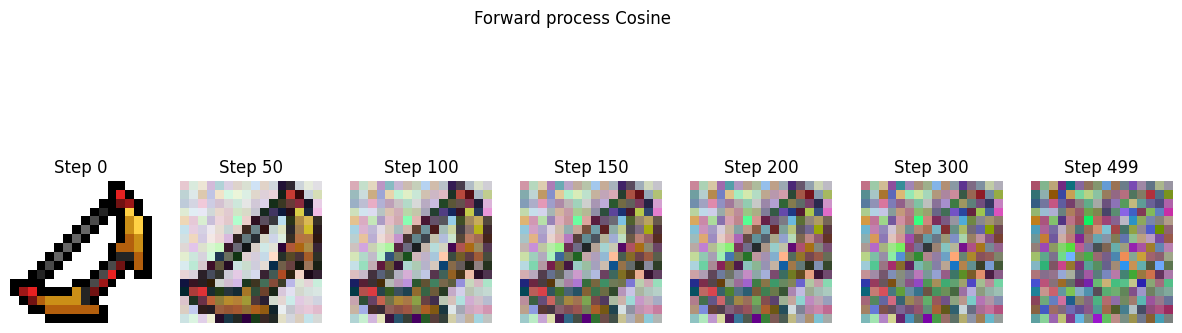

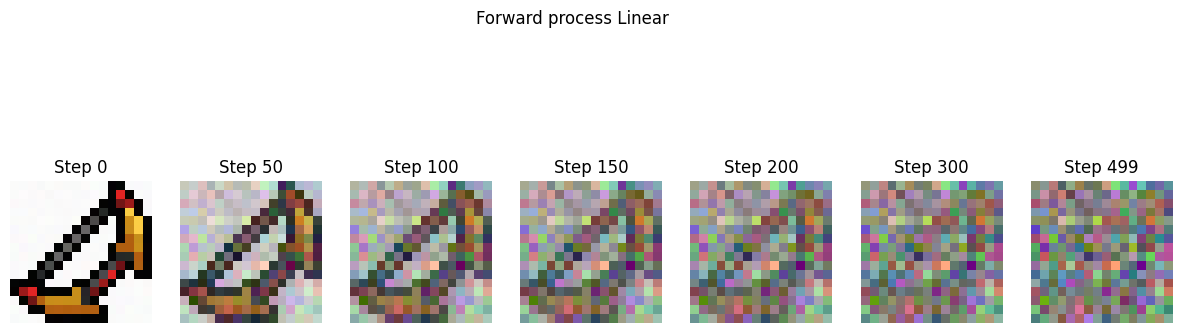

In [9]:

################## Forward process ##################
# TASK 2: Implement it in the diffusion class
xt, noise = diffusion.q_sample(x0, t)
#####################################################

noised_images = np.stack([im_normalize(tens2image(xt[idx].cpu())) for idx in range(t.shape[0])], axis=0)
show(noised_images, title='Forward process Cosine', fig_titles=fig_titles, save_path='assets/forward.png')

#compare to linear 
xt, noise = diffusionLin.q_sample(x0, t)
#####################################################

noised_images = np.stack([im_normalize(tens2image(xt[idx].cpu())) for idx in range(t.shape[0])], axis=0)
show(noised_images, title='Forward process Linear', fig_titles=fig_titles, save_path='assets/forward.png')


We notice slower noise injection in cosine schedule, exactly as we want it. 

In [10]:

################## Inverse process ##################
model = UNet(device=device)
model.eval()
model.to(device)
model.load_state_dict(torch.load('models/weights-59epochs-full-dataset.pt', map_location=device)) # load the given model
torch.manual_seed(seed)


02:44:23 - INFO: Sampling 1 new images....
100%|██████████| 499/499 [00:11<00:00, 41.88it/s]


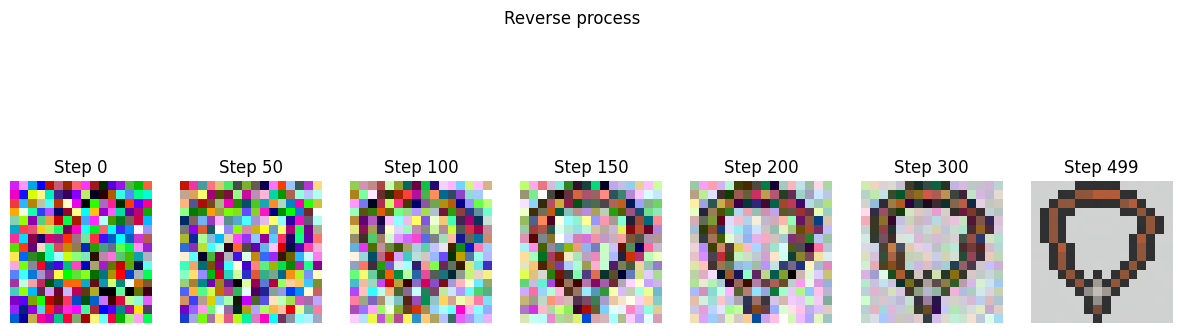

In [11]:

# TASK 3: Implement it in the diffusion class
x_new, intermediate_images = diffusion.p_sample_loop(model, 1, timesteps_to_save=t)
intermediate_images = [tens2image(img.cpu()) for img in intermediate_images]
show(intermediate_images, title='Reverse process', fig_titles=fig_titles, save_path='assets/reverse.png')
#####################################################

In [12]:
torch.save([1,2,3],"torch_save_list.pt")